In [1]:
#général
import pandas as pd
import numpy as np
import time
import os

#traitement texte
import re

#visualisation
import matplotlib.pyplot as plt

# Récupération du texte

In [2]:
import requests
from bs4 import BeautifulSoup

# URL de la page web à scraper
url = 'http://www.theatre-classique.fr/pages/programmes/PageEdition.php'

# Faites une requête HTTP pour obtenir le contenu de la page
response = requests.get(url)

# Vérifiez si la requête a réussi (statut code 200)
if response.status_code == 200:
    # Utilisez BeautifulSoup pour analyser le contenu HTML de la page
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Créez une liste vide pour stocker les éléments href se terminant par '.txt'
    txt_links = []
    
    # Trouvez tous les éléments <a> ayant un attribut href se terminant par '.txt'
    elements = soup.find_all('a', href=lambda href: href and href.endswith('.txt'))

    # Parcourez les éléments trouvés et modifiez l'attribut href pour remplacer '../txt/' par 'http://www.theatre-classique.fr/pages/txt/'
    for element in elements:
        href_value = element['href']
        new_href = href_value.replace('../txt/', 'http://www.theatre-classique.fr/pages/txt/')
        element['href'] = new_href
    # et ajoutez leur contenu (liens) à la liste txt_links
        txt_links.append(new_href)
else:
    print('La requête a échoué avec le code de statut :', response.status_code)

# Affichez la liste des liens .txt
#print(txt_links)

In [3]:
# Récupérez l'URL du fichier texte
file_url = [string for string in txt_links if 'MALADEIMAGINAIRE' in string][0]
#print('file_url OK')

# Faites une requête HTTP pour télécharger le contenu du fichier texte
file_response = requests.get(file_url)
#print('file_response OK')

# Vérifiez si le téléchargement a réussi (statut code 200)
if file_response.status_code == 200:
    # Enregistrez le contenu dans un fichier local (par exemple "doc.txt")
    doc = os.path.basename(file_url)
    with open(doc, 'wb') as file:
        file.write(file_response.content)
    #print("Le fichier a été téléchargé avec succès.\n")
else:
    pass
    #print("Le téléchargement du fichier a échoué avec le code de statut :", file_response.status_code)

In [4]:
df_tot=pd.read_fwf(doc,header=None,sep=" ",encoding = "ISO-8859-1")

# Tokenizer le texte

In [5]:
%%time
# On enlève la ponctuation et on tokenize
from nltk.tokenize import RegexpTokenizer
for c in range(0,df_tot.shape[1]):
    for r in range(0,len(df_tot)):
        if type(df_tot.iloc[r,c]) == str :
            tokenizer = RegexpTokenizer(r'\w+')
            df_tot.at[r,c] = tokenizer.tokenize(df_tot.iloc[r,c])

CPU times: total: 3.08 s
Wall time: 3.43 s


In [6]:
# Rassembler les lignes dans une colonne "cleaned"
from functools import reduce
col = []
for i in range(0, len(df_tot)):
    col.append(reduce(lambda x,y : x+y if (type(x) == list and type(y) == list) else x, df_tot[i:i+1].values.tolist()[0]))
df_tot["cleaned"] = col

# Labelliser

In [7]:
# note
def note(x):
    if 'note' in x:
        return 'note'
    else:
        pass

# personnage    
def personnage(x):
    try:
        if x[0].isupper():
            return 'personnage'
    except:
        pass

# structure
def structure(x):
    if  ('acte' or 'scène') in x:
        return 'structure'
    else:
        pass

#df_tot['label'] = df_tot['cleaned'].map(lambda x: note(x))
df_tot['label'] = df_tot['cleaned'].map(lambda x: personnage(x))
#df_tot['label'] = df_tot['cleaned'].map(lambda x: structure(x))

In [8]:
# Réduire aux deux colonnes essentielles
df_tot = df_tot.loc[:,['cleaned', 'label']]

In [9]:
# Supprimer les lignes pour lesquelles la valeur est [] dans la colonne 'cleaned'
df_tot = df_tot[df_tot['cleaned'] != '[]']

In [10]:
df_tot[df_tot['label']=='personnage']

,cleaned,label
1,"[DC, Title, LE, MALADE, IMAGINAIRE, COMÉDIE]",personnage
2,"[DC, Author, MOLIERE]",personnage
3,"[DC, Creator, FIEVRE, Paul]",personnage
4,"[DC, Publisher, FIEVRE, Paul]",personnage
5,"[DC, Subject, Comédie]",personnage
...,...,...
2456,[CHIRURGUS],personnage
2459,[CHORUS],personnage
2462,[CHIRURGUS],personnage
2465,[CHORUS],personnage


In [11]:
df = df_tot.copy()

In [12]:
df

,cleaned,label
0,[],None
1,"[DC, Title, LE, MALADE, IMAGINAIRE, COMÉDIE]",personnage
2,"[DC, Author, MOLIERE]",personnage
3,"[DC, Creator, FIEVRE, Paul]",personnage
4,"[DC, Publisher, FIEVRE, Paul]",personnage
...,...,...
2466,"[Viva, vivat, vivat, vivat, cent, fois, vivat]",None
2467,"[Novus, Doctor, qui, tam, bene, parlat, Mille,...",None
2468,"[DERNIÈRE, ENTRÉE, DE, BALLET]",personnage
2469,"[Des, médecins, des, chirurgiens, et, des, apo...",None


In [13]:
# Liste des noms
import ast 

tnom = df.loc[df['label']=='personnage','cleaned']
lnomr=[]
for lnom in tnom:
    nomp = []
    for i in lnom:
        if i.isupper():
            nomp.append(i)
        else:
            break
    lnomr.append(nomp)
lnomr[0:5]    

[['DC'], ['DC'], ['DC'], ['DC'], ['DC']]

In [14]:
# Utilisation d'une boucle pour ajouter chaque sous-liste en tant qu'élément du set
data_set = set()
for sublist in lnomr:
    data_set.add(tuple(sublist))

print(data_set)

{('SCÈNE', 'V'), ('SCÈNE', 'XIV'), ('M', 'DC', 'LXXXII', 'AVEC', 'PRIVILÈGE', 'DU', 'ROI'), ('SCÈNE', 'II'), ('PRAESES',), ('ARGAN',), ('DERNIÈRE', 'ENTRÉE', 'DE', 'BALLET'), ('PREMIÈRE', 'FEMME', 'MAURE'), ('PERSONNAGES',), ('SCÈNE', 'XIII'), ('LE', 'MALADE', 'IMAGINAIRE'), ('C',), ('CHORUS',), ('ENSEMBLE',), ('LE', 'PROLOGUE'), ('MONSIEUR', 'DIAFOIRUS'), ('UNE', 'VIEILLE'), ('PAN',), ('QUINTUS', 'DOCTOR'), ('AUTRE', 'ENTRÉE', 'DE', 'BALLET'), ('J',), ('SCÈNE', 'XI'), ('TROISIÈME', 'INTERMÈDE'), ('À',), ('LOUIS',), ('TOUS', 'DEUX'), ('TROISIÈME', 'FEMME', 'MAURE'), ('DAPHNÉ',), ('D',), ('SCÈNE', 'III'), ('SCÈNE', 'VIII'), ('TOINETTE',), ('CLÉANTE',), ('SCÈNE', 'I'), ('THOMAS', 'DIAFOIRUS'), ('DC',), ('QUATRIÈME', 'FEMME', 'MAURE'), ('À', 'PARIS'), ('QUARTUS', 'DOCTOR'), ('SCÈNE', 'VII'), ('ENTRÉE',), ('DERNIÈRE', 'ET', 'GRANDRE', 'ENTRÉE', 'DE', 'BALLET'), ('SCÈNE', 'VI'), ('LE', 'NOTAIRE'), ('ANGÉLIQUE',), ('L',), ('PRIMUS', 'DOCTOR'), ('TROUPE', 'DE', 'BERGÈRES'), ('ÉGLOGUE', 'EN', 

# Récupération de la liste des personnages

In [15]:
t1 = time.time()
# on convertit tous ces sets en listes
lnom_ = [' '.join(t) for t in data_set]

In [16]:
lnom_[0:20]

['SCÈNE V',
 'SCÈNE XIV',
 'M DC LXXXII AVEC PRIVILÈGE DU ROI',
 'SCÈNE II',
 'PRAESES',
 'ARGAN',
 'DERNIÈRE ENTRÉE DE BALLET',
 'PREMIÈRE FEMME MAURE',
 'PERSONNAGES',
 'SCÈNE XIII',
 'LE MALADE IMAGINAIRE',
 'C',
 'CHORUS',
 'ENSEMBLE',
 'LE PROLOGUE',
 'MONSIEUR DIAFOIRUS',
 'UNE VIEILLE',
 'PAN',
 'QUINTUS DOCTOR',
 'AUTRE ENTRÉE DE BALLET']

In [17]:
# on supprime les éléments à une lettre
lnom_ = [i for i in lnom_ if len(i)>1]

In [18]:
lnom_[0:20]

['SCÈNE V',
 'SCÈNE XIV',
 'M DC LXXXII AVEC PRIVILÈGE DU ROI',
 'SCÈNE II',
 'PRAESES',
 'ARGAN',
 'DERNIÈRE ENTRÉE DE BALLET',
 'PREMIÈRE FEMME MAURE',
 'PERSONNAGES',
 'SCÈNE XIII',
 'LE MALADE IMAGINAIRE',
 'CHORUS',
 'ENSEMBLE',
 'LE PROLOGUE',
 'MONSIEUR DIAFOIRUS',
 'UNE VIEILLE',
 'PAN',
 'QUINTUS DOCTOR',
 'AUTRE ENTRÉE DE BALLET',
 'SCÈNE XI']

In [19]:
# On supprime tous les éléments qui contienne un nom de structure
lnom = [i for i in lnom_ if ('SCÈNE' not in i) and ('ACTE' not in i) and ('ENTRÉE' not in i) and ('INTERMÈDE' not in i) and ('PROLOGUE' not in i)]
lnom

['M DC LXXXII AVEC PRIVILÈGE DU ROI',
 'PRAESES',
 'ARGAN',
 'PREMIÈRE FEMME MAURE',
 'PERSONNAGES',
 'LE MALADE IMAGINAIRE',
 'CHORUS',
 'ENSEMBLE',
 'MONSIEUR DIAFOIRUS',
 'UNE VIEILLE',
 'PAN',
 'QUINTUS DOCTOR',
 'LOUIS',
 'TOUS DEUX',
 'TROISIÈME FEMME MAURE',
 'DAPHNÉ',
 'TOINETTE',
 'CLÉANTE',
 'THOMAS DIAFOIRUS',
 'DC',
 'QUATRIÈME FEMME MAURE',
 'À PARIS',
 'QUARTUS DOCTOR',
 'LE NOTAIRE',
 'ANGÉLIQUE',
 'PRIMUS DOCTOR',
 'TROUPE DE BERGÈRES',
 'ÉGLOGUE EN MUSIQUE ET EN DANSE',
 'TOUS',
 'FAUNES',
 'TIRCIS',
 'TERTIUS DOCTOR',
 'DEUX ZÉPHYRS',
 'SECUNDUS DOCTOR',
 'COMÉDIE MÊLÉE DE MUSIQUE ET DE DANSES',
 'BALLET',
 'MONSIEUR BONNEFOY',
 'MONSIEUR FLEURANT',
 'TROUPE DE BERGERS',
 'SECONDE FEMME MAURE',
 'ARCHERS',
 'CHIRURGUS',
 'ARAGAN',
 'CLIMÈNE',
 'DORILAS',
 'BÉLINE',
 'PLAINTE DE LA BERGÈRE',
 'LES QUATRE AMANTS',
 'FLORE',
 'MONSIEUR PURGON',
 'BACHELIERUS',
 'BÉRALDE',
 'LOUISON',
 'POLICHINELLE']

In [20]:
# et lstage est le complémentaire
exclusion_list = ['SCÈNE', 'ACTE', 'ENTRÉE', 'INTERMÈDE', 'PROLOGUE']
lstage = [i for i in lnom_ if any(excl in i for excl in exclusion_list)]
lstage

['SCÈNE V',
 'SCÈNE XIV',
 'SCÈNE II',
 'DERNIÈRE ENTRÉE DE BALLET',
 'SCÈNE XIII',
 'LE PROLOGUE',
 'AUTRE ENTRÉE DE BALLET',
 'SCÈNE XI',
 'TROISIÈME INTERMÈDE',
 'SCÈNE III',
 'SCÈNE VIII',
 'SCÈNE I',
 'SCÈNE VII',
 'ENTRÉE',
 'DERNIÈRE ET GRANDRE ENTRÉE DE BALLET',
 'SCÈNE VI',
 'SCÈNE IX',
 'SCÈNE XII',
 'SECOND INTERMÈDE',
 'ACTE III',
 'ACTE II',
 'ENTRÉE DE BALLET',
 'SCÈNE X',
 'ACTE I',
 'SCÈNE IV',
 'PREMIER INTERMÈDE',
 'AUTRE PROLOGUE']

# Exploration

In [21]:
# On transforme les listes de df['cleaned'] en string
df['cleaned'] = list(map(lambda x : ' '.join(x),df['cleaned']))

## 1-Cleaning

In [22]:
df

,cleaned,label
0,,None
1,DC Title LE MALADE IMAGINAIRE COMÉDIE,personnage
2,DC Author MOLIERE,personnage
3,DC Creator FIEVRE Paul,personnage
4,DC Publisher FIEVRE Paul,personnage
...,...,...
2466,Viva vivat vivat vivat cent fois vivat,None
2467,Novus Doctor qui tam bene parlat Mille mille a...,None
2468,DERNIÈRE ENTRÉE DE BALLET,personnage
2469,Des médecins des chirurgiens et des apothicair...,None


## 2-Extraction des données

In [23]:
# Création d'un tableau réduit aux lignes étapes et personnages. Les lignes sont identifiées par leur index
data = [['Index', 'Acte', 'Scène', 'Personnage', 'Nb de mots']]

In [24]:
# On itère le DataFrame df en utilisant iterrows()
for index, row in df.iterrows():
    # si elle contient un mot de lnom ou lstage
    for nom in lnom + lstage:
        try:
            if nom in row["cleaned"]:
                # on appende la ligne
                data.append([index, nom, 0, 0, 0])
        except:
            print(row["cleaned"])
            continue

In [25]:
# ext

In [26]:
data

[['Index', 'Acte', 'Scène', 'Personnage', 'Nb de mots'],
 [1, 'LE MALADE IMAGINAIRE', 0, 0, 0],
 [1, 'DC', 0, 0, 0],
 [2, 'DC', 0, 0, 0],
 [3, 'DC', 0, 0, 0],
 [4, 'DC', 0, 0, 0],
 [5, 'DC', 0, 0, 0],
 [6, 'DC', 0, 0, 0],
 [7, 'DC', 0, 0, 0],
 [8, 'DC', 0, 0, 0],
 [9, 'DC', 0, 0, 0],
 [10, 'DC', 0, 0, 0],
 [11, 'DC', 0, 0, 0],
 [12, 'DC', 0, 0, 0],
 [13, 'DC', 0, 0, 0],
 [14, 'DC', 0, 0, 0],
 [15, 'DC', 0, 0, 0],
 [16, 'DC', 0, 0, 0],
 [17, 'DC', 0, 0, 0],
 [18, 'DC', 0, 0, 0],
 [19, 'DC', 0, 0, 0],
 [21, 'LE MALADE IMAGINAIRE', 0, 0, 0],
 [22, 'COMÉDIE MÊLÉE DE MUSIQUE ET DE DANSES', 0, 0, 0],
 [25, 'M DC LXXXII AVEC PRIVILÈGE DU ROI', 0, 0, 0],
 [25, 'DC', 0, 0, 0],
 [27, 'À PARIS', 0, 0, 0],
 [29, 'PERSONNAGES', 0, 0, 0],
 [30, 'FLORE', 0, 0, 0],
 [31, 'PAN', 0, 0, 0],
 [32, 'FAUNES', 0, 0, 0],
 [33, 'CLIMÈNE', 0, 0, 0],
 [34, 'DAPHNÉ', 0, 0, 0],
 [35, 'TIRCIS', 0, 0, 0],
 [36, 'DORILAS', 0, 0, 0],
 [37, 'DEUX ZÉPHYRS', 0, 0, 0],
 [38, 'TROUPE DE BERGERS', 0, 0, 0],
 [39, 'TROUPE DE

In [27]:
data_recup = data.copy()

In [28]:
data_recup

[['Index', 'Acte', 'Scène', 'Personnage', 'Nb de mots'],
 [1, 'LE MALADE IMAGINAIRE', 0, 0, 0],
 [1, 'DC', 0, 0, 0],
 [2, 'DC', 0, 0, 0],
 [3, 'DC', 0, 0, 0],
 [4, 'DC', 0, 0, 0],
 [5, 'DC', 0, 0, 0],
 [6, 'DC', 0, 0, 0],
 [7, 'DC', 0, 0, 0],
 [8, 'DC', 0, 0, 0],
 [9, 'DC', 0, 0, 0],
 [10, 'DC', 0, 0, 0],
 [11, 'DC', 0, 0, 0],
 [12, 'DC', 0, 0, 0],
 [13, 'DC', 0, 0, 0],
 [14, 'DC', 0, 0, 0],
 [15, 'DC', 0, 0, 0],
 [16, 'DC', 0, 0, 0],
 [17, 'DC', 0, 0, 0],
 [18, 'DC', 0, 0, 0],
 [19, 'DC', 0, 0, 0],
 [21, 'LE MALADE IMAGINAIRE', 0, 0, 0],
 [22, 'COMÉDIE MÊLÉE DE MUSIQUE ET DE DANSES', 0, 0, 0],
 [25, 'M DC LXXXII AVEC PRIVILÈGE DU ROI', 0, 0, 0],
 [25, 'DC', 0, 0, 0],
 [27, 'À PARIS', 0, 0, 0],
 [29, 'PERSONNAGES', 0, 0, 0],
 [30, 'FLORE', 0, 0, 0],
 [31, 'PAN', 0, 0, 0],
 [32, 'FAUNES', 0, 0, 0],
 [33, 'CLIMÈNE', 0, 0, 0],
 [34, 'DAPHNÉ', 0, 0, 0],
 [35, 'TIRCIS', 0, 0, 0],
 [36, 'DORILAS', 0, 0, 0],
 [37, 'DEUX ZÉPHYRS', 0, 0, 0],
 [38, 'TROUPE DE BERGERS', 0, 0, 0],
 [39, 'TROUPE DE

In [29]:
# bon il y a un petit soucis avec les chiffres romains. On va supprimer les lignes inutiles donnant la priorité par rapport 
# à une liste
lstage.sort(reverse=True)

In [30]:
lstage

['TROISIÈME INTERMÈDE',
 'SECOND INTERMÈDE',
 'SCÈNE XIV',
 'SCÈNE XIII',
 'SCÈNE XII',
 'SCÈNE XI',
 'SCÈNE X',
 'SCÈNE VIII',
 'SCÈNE VII',
 'SCÈNE VI',
 'SCÈNE V',
 'SCÈNE IX',
 'SCÈNE IV',
 'SCÈNE III',
 'SCÈNE II',
 'SCÈNE I',
 'PREMIER INTERMÈDE',
 'LE PROLOGUE',
 'ENTRÉE DE BALLET',
 'ENTRÉE',
 'DERNIÈRE ET GRANDRE ENTRÉE DE BALLET',
 'DERNIÈRE ENTRÉE DE BALLET',
 'AUTRE PROLOGUE',
 'AUTRE ENTRÉE DE BALLET',
 'ACTE III',
 'ACTE II',
 'ACTE I']

In [31]:
data = data_recup.copy()

In [32]:
# On va marquer 'TBS' avec cette liste de priorité les lignes en doublons dans data
for i in range(len(data)):
    try:
        if data[i][0] == data[i+1][0]:
            # On vérifie quel genre de doublon c'est
            if data[i][1] in lstage:
                print('clc')
                i_ = lstage.index(data[i][1])
                i__ = lstage.index(data[i+1][1])
                if i__ > i_:
                    print(data[i+1][1], '>', data[i][1])
                    data[i+1][2] = 'TBS'
                else:
                    print(data[i+1][1], '<', data[i][1])
                    data[i][2] = 'TBS'
            else:
                data[i+1][2] = 'TBS'
    except:
        continue

clc
ENTRÉE < AUTRE ENTRÉE DE BALLET
clc
ENTRÉE DE BALLET < ENTRÉE
clc
ENTRÉE DE BALLET < ENTRÉE
clc
DERNIÈRE ET GRANDRE ENTRÉE DE BALLET > ENTRÉE
clc
ENTRÉE DE BALLET < DERNIÈRE ET GRANDRE ENTRÉE DE BALLET
clc
SCÈNE I > SCÈNE II
clc
SCÈNE III < SCÈNE II
clc
SCÈNE I > SCÈNE III
clc
SCÈNE IV < SCÈNE I
clc
SCÈNE VI < SCÈNE V
clc
SCÈNE VII < SCÈNE V
clc
SCÈNE VI > SCÈNE VII
clc
SCÈNE VIII < SCÈNE V
clc
SCÈNE VII > SCÈNE VIII
clc
SCÈNE VI > SCÈNE VII
clc
ENTRÉE DE BALLET < ENTRÉE
clc
ACTE I > ACTE II
clc
SCÈNE I > SCÈNE II
clc
SCÈNE III < SCÈNE II
clc
SCÈNE I > SCÈNE III
clc
SCÈNE IV < SCÈNE I
clc
SCÈNE VI < SCÈNE V
clc
SCÈNE VII < SCÈNE V
clc
SCÈNE VI > SCÈNE VII
clc
SCÈNE VIII < SCÈNE V
clc
SCÈNE VII > SCÈNE VIII
clc
SCÈNE VI > SCÈNE VII
clc
SCÈNE IX < SCÈNE I
clc
ENTRÉE DE BALLET < ENTRÉE
clc
ACTE II > ACTE III
clc
ACTE I > ACTE II
clc
SCÈNE I > SCÈNE II
clc
SCÈNE III < SCÈNE II
clc
SCÈNE I > SCÈNE III
clc
SCÈNE IV < SCÈNE I
clc
SCÈNE VI < SCÈNE V
clc
SCÈNE VII < SCÈNE V
clc
SCÈNE VI > S

In [33]:
data

[['Index', 'Acte', 'Scène', 'Personnage', 'Nb de mots'],
 [1, 'LE MALADE IMAGINAIRE', 0, 0, 0],
 [1, 'DC', 'TBS', 0, 0],
 [2, 'DC', 0, 0, 0],
 [3, 'DC', 0, 0, 0],
 [4, 'DC', 0, 0, 0],
 [5, 'DC', 0, 0, 0],
 [6, 'DC', 0, 0, 0],
 [7, 'DC', 0, 0, 0],
 [8, 'DC', 0, 0, 0],
 [9, 'DC', 0, 0, 0],
 [10, 'DC', 0, 0, 0],
 [11, 'DC', 0, 0, 0],
 [12, 'DC', 0, 0, 0],
 [13, 'DC', 0, 0, 0],
 [14, 'DC', 0, 0, 0],
 [15, 'DC', 0, 0, 0],
 [16, 'DC', 0, 0, 0],
 [17, 'DC', 0, 0, 0],
 [18, 'DC', 0, 0, 0],
 [19, 'DC', 0, 0, 0],
 [21, 'LE MALADE IMAGINAIRE', 0, 0, 0],
 [22, 'COMÉDIE MÊLÉE DE MUSIQUE ET DE DANSES', 0, 0, 0],
 [25, 'M DC LXXXII AVEC PRIVILÈGE DU ROI', 0, 0, 0],
 [25, 'DC', 'TBS', 0, 0],
 [27, 'À PARIS', 0, 0, 0],
 [29, 'PERSONNAGES', 0, 0, 0],
 [30, 'FLORE', 0, 0, 0],
 [31, 'PAN', 0, 0, 0],
 [32, 'FAUNES', 0, 0, 0],
 [33, 'CLIMÈNE', 0, 0, 0],
 [34, 'DAPHNÉ', 0, 0, 0],
 [35, 'TIRCIS', 0, 0, 0],
 [36, 'DORILAS', 0, 0, 0],
 [37, 'DEUX ZÉPHYRS', 0, 0, 0],
 [38, 'TROUPE DE BERGERS', 0, 0, 0],
 [39, 'T

In [34]:
# On supprime les doublons
data = [x for x in data if 'TBS' not in x]

In [35]:
#vérification
[x for x in data if x[1] in lstage]

[[54, 'LE PROLOGUE', 0, 0, 0],
 [96, 'ENTRÉE DE BALLET', 0, 0, 0],
 [154, 'ENTRÉE DE BALLET', 0, 0, 0],
 [169, 'ENTRÉE DE BALLET', 0, 0, 0],
 [171, 'AUTRE PROLOGUE', 0, 0, 0],
 [194, 'ACTE I', 0, 0, 0],
 [195, 'SCÈNE I', 0, 0, 0],
 [198, 'SCÈNE II', 0, 0, 0],
 [265, 'SCÈNE III', 0, 0, 0],
 [274, 'SCÈNE IV', 0, 0, 0],
 [355, 'SCÈNE V', 0, 0, 0],
 [594, 'SCÈNE VI', 0, 0, 0],
 [693, 'SCÈNE VII', 0, 0, 0],
 [754, 'SCÈNE VIII', 0, 0, 0],
 [769, 'PREMIER INTERMÈDE', 0, 0, 0],
 [854, 'ENTRÉE DE BALLET', 0, 0, 0],
 [963, 'ACTE II', 0, 0, 0],
 [964, 'SCÈNE I', 0, 0, 0],
 [979, 'SCÈNE II', 0, 0, 0],
 [1036, 'SCÈNE III', 0, 0, 0],
 [1055, 'SCÈNE IV', 0, 0, 0],
 [1076, 'SCÈNE V', 0, 0, 0],
 [1263, 'SCÈNE VI', 0, 0, 0],
 [1398, 'SCÈNE VII', 0, 0, 0],
 [1407, 'SCÈNE VIII', 0, 0, 0],
 [1548, 'SCÈNE IX', 0, 0, 0],
 [1567, 'SECOND INTERMÈDE', 0, 0, 0],
 [1642, 'ENTRÉE DE BALLET', 0, 0, 0],
 [1644, 'ACTE III', 0, 0, 0],
 [1645, 'SCÈNE I', 0, 0, 0],
 [1659, 'SCÈNE II', 0, 0, 0],
 [1670, 'SCÈNE III', 0, 0

In [36]:
# TRICHE : on cherche l'index du df de la première ligne qui contient 'ACTE' dans data
start_index = data.index([194, 'ACTE I', 0, 0, 0])

In [37]:
# on redessine data en data_ à partir de cette ligne
data_ = data.copy()
data_ = data_[0:1]+data_[start_index:]

In [38]:
data_

[['Index', 'Acte', 'Scène', 'Personnage', 'Nb de mots'],
 [194, 'ACTE I', 0, 0, 0],
 [195, 'SCÈNE I', 0, 0, 0],
 [196, 'ARGAN', 0, 0, 0],
 [198, 'SCÈNE II', 0, 0, 0],
 [199, 'TOINETTE', 0, 0, 0],
 [201, 'ARGAN', 0, 0, 0],
 [203, 'TOINETTE', 0, 0, 0],
 [205, 'ARGAN', 0, 0, 0],
 [207, 'TOINETTE', 0, 0, 0],
 [209, 'ARGAN', 0, 0, 0],
 [211, 'TOINETTE', 0, 0, 0],
 [213, 'ARGAN', 0, 0, 0],
 [215, 'TOINETTE', 0, 0, 0],
 [217, 'ARGAN', 0, 0, 0],
 [219, 'TOINETTE', 0, 0, 0],
 [221, 'ARGAN', 0, 0, 0],
 [223, 'TOINETTE', 0, 0, 0],
 [225, 'ARGAN', 0, 0, 0],
 [227, 'TOINETTE', 0, 0, 0],
 [229, 'ARGAN', 0, 0, 0],
 [231, 'TOINETTE', 0, 0, 0],
 [233, 'ARGAN', 0, 0, 0],
 [235, 'TOINETTE', 0, 0, 0],
 [237, 'ARGAN', 0, 0, 0],
 [239, 'TOINETTE', 0, 0, 0],
 [241, 'ARGAN', 0, 0, 0],
 [243, 'TOINETTE', 0, 0, 0],
 [245, 'ARGAN', 0, 0, 0],
 [247, 'TOINETTE', 0, 0, 0],
 [249, 'ARGAN', 0, 0, 0],
 [251, 'TOINETTE', 0, 0, 0],
 [253, 'ARGAN', 0, 0, 0],
 [255, 'TOINETTE', 0, 0, 0],
 [257, 'ARGAN', 0, 0, 0],
 [259, '

In [39]:
data_recup = data_.copy()

In [40]:
ma_liste = [i[1] for i in data_]
mon_set = set()

# Parcourez les éléments de la liste principale
for element in ma_liste:
    # Si l'élément est une liste, parcourez ses éléments internes
    if isinstance(element, list):
        for sous_element in element:
            mon_set.add(sous_element)
    else:
        mon_set.add(element)

# Affichez l'ensemble résultant
print(mon_set)

{'TROISIÈME INTERMÈDE', 'SCÈNE III', 'CLÉANTE', 'ACTE I', 'SCÈNE II', 'SCÈNE XIII', 'TROISIÈME FEMME MAURE', 'BACHELIERUS', 'CHORUS', 'QUATRIÈME FEMME MAURE', 'SCÈNE XIV', 'BÉLINE', 'POLICHINELLE', 'BÉRALDE', 'ANGÉLIQUE', 'ENSEMBLE', 'PREMIÈRE FEMME MAURE', 'BALLET', 'MONSIEUR DIAFOIRUS', 'SCÈNE XI', 'ACTE II', 'THOMAS DIAFOIRUS', 'ARCHERS', 'ACTE III', 'SCÈNE I', 'UNE VIEILLE', 'SCÈNE V', 'SECONDE FEMME MAURE', 'SCÈNE XII', 'QUINTUS DOCTOR', 'SCÈNE IV', 'SCÈNE VII', 'ENTRÉE DE BALLET', 'TERTIUS DOCTOR', 'LOUIS', 'SECOND INTERMÈDE', 'CHIRURGUS', 'SCÈNE X', 'Acte', 'PRIMUS DOCTOR', 'ARGAN', 'ARAGAN', 'MONSIEUR FLEURANT', 'MONSIEUR PURGON', 'QUARTUS DOCTOR', 'PRAESES', 'TOINETTE', 'LE NOTAIRE', 'SCÈNE VIII', 'SCÈNE VI', 'PREMIER INTERMÈDE', 'SECUNDUS DOCTOR', 'SCÈNE IX'}


In [41]:
# on met les noms à leur place
for r in range(1, len(data_)):
    if data_[r][1] in lnom:
        
        data_[r][3]=data_[r][1]
        data_[r][1]=0

In [42]:
data_

[['Index', 'Acte', 'Scène', 'Personnage', 'Nb de mots'],
 [194, 'ACTE I', 0, 0, 0],
 [195, 'SCÈNE I', 0, 0, 0],
 [196, 0, 0, 'ARGAN', 0],
 [198, 'SCÈNE II', 0, 0, 0],
 [199, 0, 0, 'TOINETTE', 0],
 [201, 0, 0, 'ARGAN', 0],
 [203, 0, 0, 'TOINETTE', 0],
 [205, 0, 0, 'ARGAN', 0],
 [207, 0, 0, 'TOINETTE', 0],
 [209, 0, 0, 'ARGAN', 0],
 [211, 0, 0, 'TOINETTE', 0],
 [213, 0, 0, 'ARGAN', 0],
 [215, 0, 0, 'TOINETTE', 0],
 [217, 0, 0, 'ARGAN', 0],
 [219, 0, 0, 'TOINETTE', 0],
 [221, 0, 0, 'ARGAN', 0],
 [223, 0, 0, 'TOINETTE', 0],
 [225, 0, 0, 'ARGAN', 0],
 [227, 0, 0, 'TOINETTE', 0],
 [229, 0, 0, 'ARGAN', 0],
 [231, 0, 0, 'TOINETTE', 0],
 [233, 0, 0, 'ARGAN', 0],
 [235, 0, 0, 'TOINETTE', 0],
 [237, 0, 0, 'ARGAN', 0],
 [239, 0, 0, 'TOINETTE', 0],
 [241, 0, 0, 'ARGAN', 0],
 [243, 0, 0, 'TOINETTE', 0],
 [245, 0, 0, 'ARGAN', 0],
 [247, 0, 0, 'TOINETTE', 0],
 [249, 0, 0, 'ARGAN', 0],
 [251, 0, 0, 'TOINETTE', 0],
 [253, 0, 0, 'ARGAN', 0],
 [255, 0, 0, 'TOINETTE', 0],
 [257, 0, 0, 'ARGAN', 0],
 [259, 0

In [43]:
data_2 = data_.copy()

In [44]:
# on fait la même chose pour ACTE
# Pas besoin il est déjà à sa place

In [45]:
data_2

[['Index', 'Acte', 'Scène', 'Personnage', 'Nb de mots'],
 [194, 'ACTE I', 0, 0, 0],
 [195, 'SCÈNE I', 0, 0, 0],
 [196, 0, 0, 'ARGAN', 0],
 [198, 'SCÈNE II', 0, 0, 0],
 [199, 0, 0, 'TOINETTE', 0],
 [201, 0, 0, 'ARGAN', 0],
 [203, 0, 0, 'TOINETTE', 0],
 [205, 0, 0, 'ARGAN', 0],
 [207, 0, 0, 'TOINETTE', 0],
 [209, 0, 0, 'ARGAN', 0],
 [211, 0, 0, 'TOINETTE', 0],
 [213, 0, 0, 'ARGAN', 0],
 [215, 0, 0, 'TOINETTE', 0],
 [217, 0, 0, 'ARGAN', 0],
 [219, 0, 0, 'TOINETTE', 0],
 [221, 0, 0, 'ARGAN', 0],
 [223, 0, 0, 'TOINETTE', 0],
 [225, 0, 0, 'ARGAN', 0],
 [227, 0, 0, 'TOINETTE', 0],
 [229, 0, 0, 'ARGAN', 0],
 [231, 0, 0, 'TOINETTE', 0],
 [233, 0, 0, 'ARGAN', 0],
 [235, 0, 0, 'TOINETTE', 0],
 [237, 0, 0, 'ARGAN', 0],
 [239, 0, 0, 'TOINETTE', 0],
 [241, 0, 0, 'ARGAN', 0],
 [243, 0, 0, 'TOINETTE', 0],
 [245, 0, 0, 'ARGAN', 0],
 [247, 0, 0, 'TOINETTE', 0],
 [249, 0, 0, 'ARGAN', 0],
 [251, 0, 0, 'TOINETTE', 0],
 [253, 0, 0, 'ARGAN', 0],
 [255, 0, 0, 'TOINETTE', 0],
 [257, 0, 0, 'ARGAN', 0],
 [259, 0

In [46]:
# on fait la même chose pour Scène
for r in range(1, len(data_2)):
    try:
        if 'SCÈNE' in data_2[r][1]:
            data_2[r][2] = data_2[r][1]
            data_2[r][1] = 0
    except:
        continue

In [47]:
data_2

[['Index', 'Acte', 'Scène', 'Personnage', 'Nb de mots'],
 [194, 'ACTE I', 0, 0, 0],
 [195, 0, 'SCÈNE I', 0, 0],
 [196, 0, 0, 'ARGAN', 0],
 [198, 0, 'SCÈNE II', 0, 0],
 [199, 0, 0, 'TOINETTE', 0],
 [201, 0, 0, 'ARGAN', 0],
 [203, 0, 0, 'TOINETTE', 0],
 [205, 0, 0, 'ARGAN', 0],
 [207, 0, 0, 'TOINETTE', 0],
 [209, 0, 0, 'ARGAN', 0],
 [211, 0, 0, 'TOINETTE', 0],
 [213, 0, 0, 'ARGAN', 0],
 [215, 0, 0, 'TOINETTE', 0],
 [217, 0, 0, 'ARGAN', 0],
 [219, 0, 0, 'TOINETTE', 0],
 [221, 0, 0, 'ARGAN', 0],
 [223, 0, 0, 'TOINETTE', 0],
 [225, 0, 0, 'ARGAN', 0],
 [227, 0, 0, 'TOINETTE', 0],
 [229, 0, 0, 'ARGAN', 0],
 [231, 0, 0, 'TOINETTE', 0],
 [233, 0, 0, 'ARGAN', 0],
 [235, 0, 0, 'TOINETTE', 0],
 [237, 0, 0, 'ARGAN', 0],
 [239, 0, 0, 'TOINETTE', 0],
 [241, 0, 0, 'ARGAN', 0],
 [243, 0, 0, 'TOINETTE', 0],
 [245, 0, 0, 'ARGAN', 0],
 [247, 0, 0, 'TOINETTE', 0],
 [249, 0, 0, 'ARGAN', 0],
 [251, 0, 0, 'TOINETTE', 0],
 [253, 0, 0, 'ARGAN', 0],
 [255, 0, 0, 'TOINETTE', 0],
 [257, 0, 0, 'ARGAN', 0],
 [259, 0

In [48]:
data_ = data_2.copy()

In [49]:
# Maintenant dans les lignes où on a le nom des personnages on va compter le nb de mot dans la tirade
# On stock le n° de la ligne considérée
list_l = [data_[i][0] for i in range(1,len(data_)) if data_[i][3]!=0]

In [50]:
# On stocke dans des variable l'index des lignes de départ (exlus) et de fin de la tirade (exclus)
for i in range(0,len(list_l)):
    db = list_l[i]
    try :
        fi = list_l[i+1]
    except :
        fi = db + 2
    try :
        # On stocke dans une variable le nombre de mots entre db exclus jusqu'à fi exclus
        nb = reduce(lambda x,y : x+y, [len(df.loc[df.index ==r,"cleaned"].values.tolist()[0]) for r in range(db+1,fi)])
        # Et on met ce nombre dans la dernière cellule de la ligne correspondant à db dans data_
        index = None
        for i, row in enumerate(data_):
            if row[0] == db:
                index = i
                break
        data_[index][-1] = nb
    except :
        continue

In [51]:
db

2468

In [52]:
#on va colorer les lignes caractéristiques détectées et voir ce que ça donne sur un doc excel

# Indices des lignes à colorer
indices_to_color = [data[r][0] for r in range(1, len(data))]

# Création de la fonction de mise en forme pour colorer les lignes spécifiques
def highlight_row(row):
    if row.name in indices_to_color:
        return ['background-color: yellow'] * len(row)
    else:
        return [''] * len(row)

# Application de la fonction de mise en forme au DataFrame
styled_df = df.style.apply(highlight_row, axis=1)

# Affichage du DataFrame stylisé
styled_df.to_excel("df_color.xlsx")
os.startfile("df_color.xlsx")

In [53]:
data_3 = data_.copy()
data_3

[['Index', 'Acte', 'Scène', 'Personnage', 'Nb de mots'],
 [194, 'ACTE I', 0, 0, 0],
 [195, 0, 'SCÈNE I', 0, 0],
 [196, 0, 0, 'ARGAN', 404],
 [198, 0, 'SCÈNE II', 0, 0],
 [199, 0, 0, 'TOINETTE', 7],
 [201, 0, 0, 'ARGAN', 163],
 [203, 0, 0, 'TOINETTE', 244],
 [205, 0, 0, 'ARGAN', 13],
 [207, 0, 0, 'TOINETTE', 2],
 [209, 0, 0, 'ARGAN', 6],
 [211, 0, 0, 'TOINETTE', 2],
 [213, 0, 0, 'ARGAN', 16],
 [215, 0, 0, 'TOINETTE', 2],
 [217, 0, 0, 'ARGAN', 14],
 [219, 0, 0, 'TOINETTE', 2],
 [221, 0, 0, 'ARGAN', 197],
 [223, 0, 0, 'TOINETTE', 58],
 [225, 0, 0, 'ARGAN', 30],
 [227, 0, 0, 'TOINETTE', 93],
 [229, 0, 0, 'ARGAN', 12],
 [231, 0, 0, 'TOINETTE', 30],
 [233, 0, 0, 'ARGAN', 21],
 [235, 0, 0, 'TOINETTE', 2],
 [237, 0, 0, 'ARGAN', 15],
 [239, 0, 0, 'TOINETTE', 2],
 [241, 0, 0, 'ARGAN', 65],
 [243, 0, 0, 'TOINETTE', 41],
 [245, 0, 0, 'ARGAN', 55],
 [247, 0, 0, 'TOINETTE', 129],
 [249, 0, 0, 'ARGAN', 137],
 [251, 0, 0, 'TOINETTE', 14],
 [253, 0, 0, 'ARGAN', 30],
 [255, 0, 0, 'TOINETTE', 114],
 [257

In [54]:
# Maintenant on mais les acte et les scènes dans les lignes au même niveau que les personnages dans data_
# Si la ligne contient Acte on copie cette données dans les cellules du dessous jusqu'à rencontrer une 
# nouvelle cellule différente de 0
for r in range(1,len(data_)):
    if data_[r][1] != 0:
        i = r+1
        try:
            while data_[i][1] == 0:
                data_[i][1] = data_[r][1]
                i = i+1
        except:
            break

In [55]:
# Même chose avec les scène
for r in range(1,len(data_)):
    if data_[r][2] != 0:
        i = r+1
        try:
            while data_[i][2] == 0:
                data_[i][2] = data_[r][2]
                i = i+1
        except:
            break

In [56]:
# Et pour terminer on supprime toutes les lignes qui n'ont pas de personnage
data_f = [row for row in data_ if row[3]!=0]

In [57]:
# On convertif en df
df_t = pd.DataFrame(data_f[1:], columns = data_f[0])

In [58]:
df_t

,Index,Acte,Scène,Personnage,Nb de mots
0,196,ACTE I,SCÈNE I,ARGAN,404
1,199,ACTE I,SCÈNE II,TOINETTE,7
2,201,ACTE I,SCÈNE II,ARGAN,163
3,203,ACTE I,SCÈNE II,TOINETTE,244
4,205,ACTE I,SCÈNE II,ARGAN,13
...,...,...,...,...,...
1016,2456,ENTRÉE DE BALLET,SCÈNE XIV,CHIRURGUS,94
1017,2459,ENTRÉE DE BALLET,SCÈNE XIV,CHORUS,127
1018,2462,ENTRÉE DE BALLET,SCÈNE XIV,CHIRURGUS,136
1019,2465,ENTRÉE DE BALLET,SCÈNE XIV,CHORUS,126


In [59]:
series = df_t.groupby(['Acte','Personnage'])['Nb de mots'].sum()

In [60]:
series

Acte                 Personnage           
ACTE I               ANGÉLIQUE                 2703
                     ARGAN                     7858
                     BÉLINE                    2396
                     LE NOTAIRE                1478
                     TOINETTE                  6294
ACTE II              ANGÉLIQUE                 3405
                     ARAGAN                      78
                     ARGAN                     6009
                     BÉLINE                    1235
                     BÉRALDE                    714
                     CLÉANTE                   3182
                     LOUIS                     1631
                     MONSIEUR DIAFOIRUS        2556
                     THOMAS DIAFOIRUS          2823
                     TOINETTE                  3045
ACTE III             ANGÉLIQUE                 1526
                     ARGAN                     7534
                     BÉLINE                     918
                     

## Visualisation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Index(['ANGÉLIQUE', 'ARGAN', 'BÉLINE', 'LE NOTAIRE', 'TOINETTE', 'ANGÉLIQUE',
       'ARAGAN', 'ARGAN', 'BÉLINE', 'BÉRALDE', 'CLÉANTE', 'LOUIS',
       'MONSIEUR DIAFOIRUS', 'THOMAS DIAFOIRUS', 'TOINETTE', 'ANGÉLIQUE',
       'ARGAN', 'BÉLINE', 'BÉRALDE', 'CLÉANTE', 'MONSIEUR FLEURANT',
       'MONSIEUR PURGON', 'TOINETTE', 'ARCHERS', 'BACHELIERUS', 'BALLET',
       'CHIRURGUS', 'CHORUS', 'POLICHINELLE', 'PRAESES', 'PRIMUS DOCTOR',
       'QUARTUS DOCTOR', 'QUINTUS DOCTOR', 'SECUNDUS DOCTOR', 'TERTIUS DOCTOR',
       'ARCHERS', 'BALLET', 'POLICHINELLE', 'UNE VIEILLE', 'BALLET',
       'ENSEMBLE', 'PREMIÈRE FEMME MAURE', 'QUATRIÈME FEMME MAURE',
       'SECONDE FEMME MAURE', 'TROISIÈME FEMME MAURE', 'BALLET'],
      dtype='object', name='Personnage')
Index(['ACTE I', 'ACTE I', 'ACTE I', 'ACTE I', 'ACTE I', 'ACTE II', 'ACTE II',
       'ACTE II', 'ACTE II', 'ACTE II', 'ACTE II', 'ACTE II', 'ACTE II',
       'ACTE II', 'ACTE II', 'ACTE III', 'ACTE III', 'ACTE III', 'ACTE III',
       'ACT

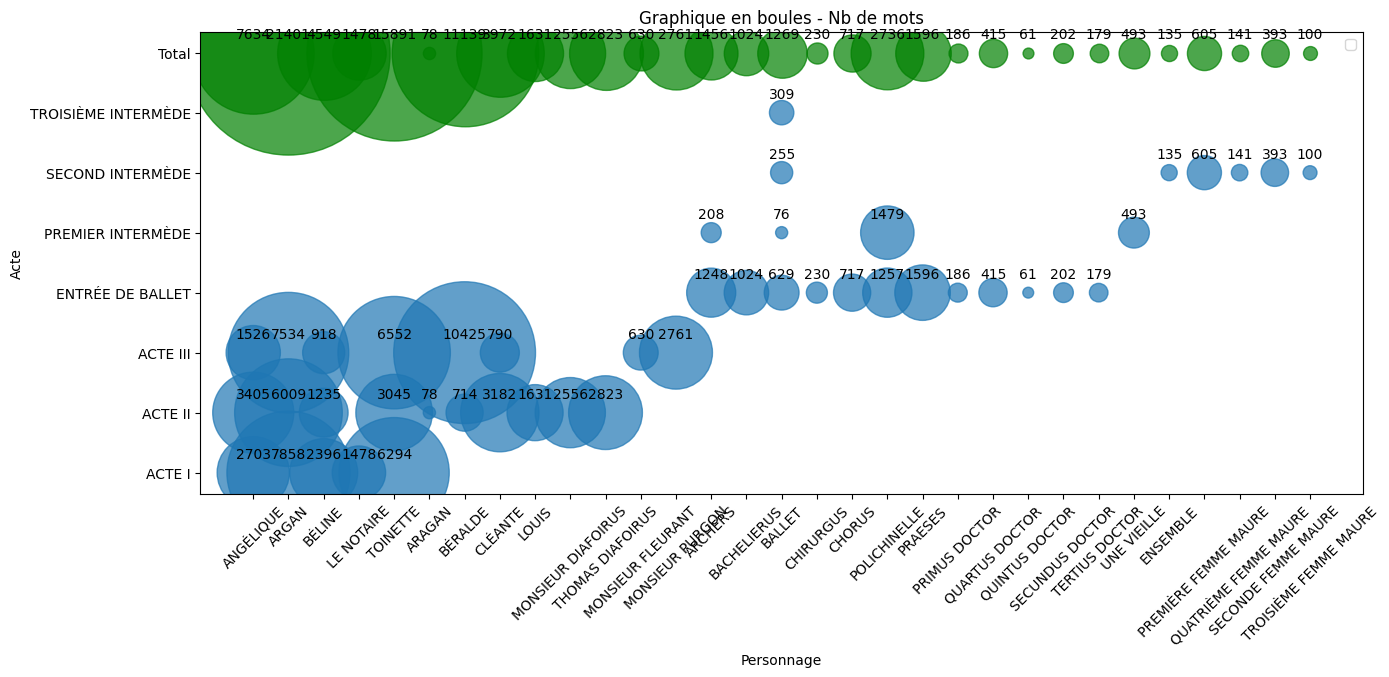

temps de traitement =  9.564322471618652


In [61]:
# Calculer le total par personnage
total_par_personnage = series.groupby(level='Personnage').sum()

# Création du graphique en boules initial
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(series.index.get_level_values('Personnage'), series.index.get_level_values('Acte'),
           s=series.values, alpha=0.7)

# Ajouter des boules pour le total par personnage
for personnage, total in total_par_personnage.items():
    ax.scatter(personnage, "Total", s=total, c='green', alpha=0.7)#, label=f'Total {personnage}')

# Configuration des axes et du titre
ax.set_xlabel('Personnage')
ax.set_ylabel('Acte')
ax.set_title('Graphique en boules - Nb de mots')
plt.xticks(rotation=45)

# Vérification
print(series.index.get_level_values('Personnage')) 
print(series.index.get_level_values('Acte'))

# Afficher la valeur dans la boule pour le graphique initial
for x, y, val in zip(series.index.get_level_values('Personnage'), series.index.get_level_values('Acte'), series.values):
    ax.annotate(str(val), (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Afficher la valeur dans la boule pour le total par personnage
for personnage, total in total_par_personnage.items():
    ax.annotate(str(total), (personnage, "Total"), textcoords="offset points", xytext=(0, 10), ha='center')

# Légende pour les boules du total par personnage
ax.legend()

# Affichage du graphique
plt.show()
print("temps de traitement = ", time.time()-t1)

# Filtrage des éléments de visualisation

In [67]:
list_pers = ['ANGÉLIQUE', 'ARGAN', 'BÉLINE', 'LE NOTAIRE', 'TOINETTE', 
             'ANGÉLIQUE','BÉRALDE', 'CLÉANTE', 'LOUIS', 'MONSIEUR DIAFOIRUS', 
             'THOMAS DIAFOIRUS',  'MONSIEUR FLEURANT', 'MONSIEUR PURGON']

list_stage = ['ACTE I','ACTE II', 'ACTE III']

In [68]:
df_t_select = df_t[df_t['Acte'].isin(list_stage) & df_t['Personnage'].isin(list_pers)]

In [69]:
series = df_t_select.groupby(['Acte','Personnage'])['Nb de mots'].sum()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Index(['ANGÉLIQUE', 'ARGAN', 'BÉLINE', 'LE NOTAIRE', 'TOINETTE', 'ANGÉLIQUE',
       'ARGAN', 'BÉLINE', 'BÉRALDE', 'CLÉANTE', 'LOUIS', 'MONSIEUR DIAFOIRUS',
       'THOMAS DIAFOIRUS', 'TOINETTE', 'ANGÉLIQUE', 'ARGAN', 'BÉLINE',
       'BÉRALDE', 'CLÉANTE', 'MONSIEUR FLEURANT', 'MONSIEUR PURGON',
       'TOINETTE'],
      dtype='object', name='Personnage')
Index(['ACTE I', 'ACTE I', 'ACTE I', 'ACTE I', 'ACTE I', 'ACTE II', 'ACTE II',
       'ACTE II', 'ACTE II', 'ACTE II', 'ACTE II', 'ACTE II', 'ACTE II',
       'ACTE II', 'ACTE III', 'ACTE III', 'ACTE III', 'ACTE III', 'ACTE III',
       'ACTE III', 'ACTE III', 'ACTE III'],
      dtype='object', name='Acte')


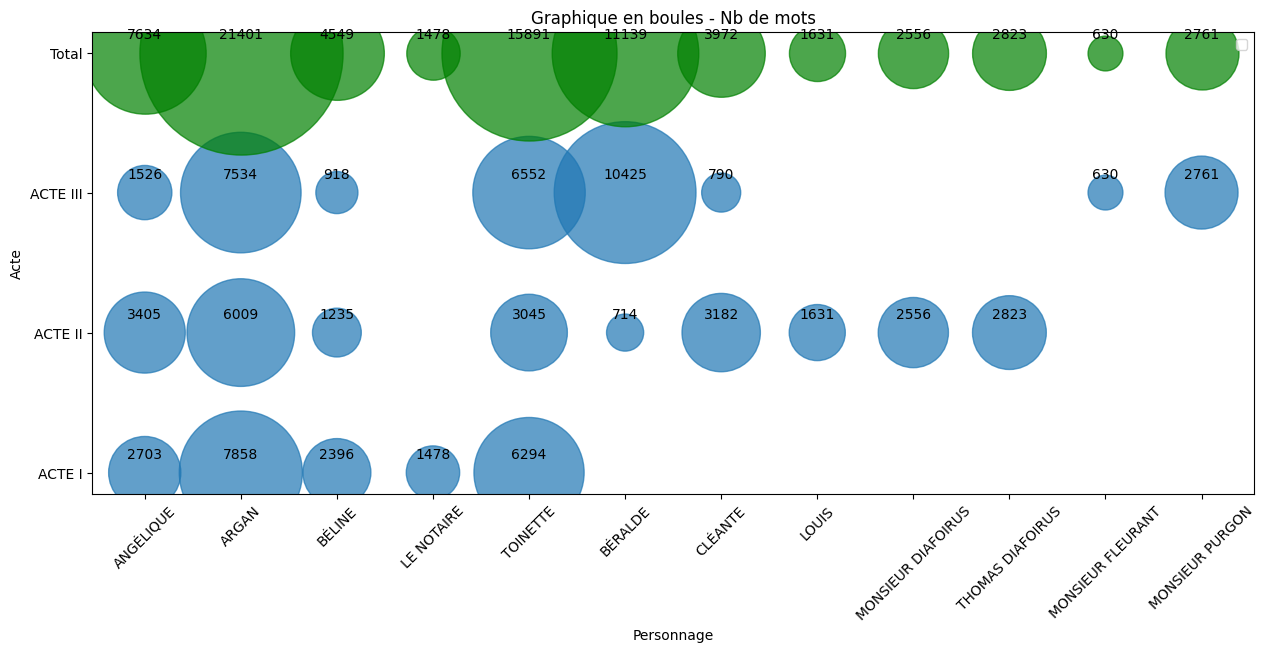

temps de traitement =  891.8573641777039


In [70]:
# Calculer le total par personnage
total_par_personnage = series.groupby(level='Personnage').sum()

# Création du graphique en boules initial
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(series.index.get_level_values('Personnage'), series.index.get_level_values('Acte'),
           s=series.values, alpha=0.7)

# Ajouter des boules pour le total par personnage
for personnage, total in total_par_personnage.items():
    ax.scatter(personnage, "Total", s=total, c='green', alpha=0.7)#, label=f'Total {personnage}')

# Configuration des axes et du titre
ax.set_xlabel('Personnage')
ax.set_ylabel('Acte')
ax.set_title('Graphique en boules - Nb de mots')
plt.xticks(rotation=45)

# Vérification
print(series.index.get_level_values('Personnage')) 
print(series.index.get_level_values('Acte'))

# Afficher la valeur dans la boule pour le graphique initial
for x, y, val in zip(series.index.get_level_values('Personnage'), series.index.get_level_values('Acte'), series.values):
    ax.annotate(str(val), (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Afficher la valeur dans la boule pour le total par personnage
for personnage, total in total_par_personnage.items():
    ax.annotate(str(total), (personnage, "Total"), textcoords="offset points", xytext=(0, 10), ha='center')

# Légende pour les boules du total par personnage
ax.legend()

# Affichage du graphique
plt.show()
print("temps de traitement = ", time.time()-t1)